# AC Project

## Imports

In [257]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import lightgbm as lgb

## Exploratory Analysis

We first focused on the ``teams.csv`` dataset, before including other datasets.

Based on the feedback of our teacher, we tried to make a shift in our model, where we would use the statistics of one year to predict if that specific team went to the playoffs in the following season. However, we found the sample  size varied throughtout the seasons contained by our dataset, demonstrated here:

In [258]:
file_path = "basketballPlayoffs/teams.csv"
data = pd.read_csv(file_path)
year_counts = data['year'].value_counts()
year_counts = year_counts.sort_index()

for year, count in year_counts.items():
    print(f"Year {year}: {count} rows")
print("\n")

for i in range(11):
    year_data = data[data['year'] == i]
    team_names = year_data['name'].tolist()

    if team_names:
        print(f"Teams in Year {i}:")
        for team_name in team_names:
            print(team_name)
    print("\n")

Year 1: 16 rows
Year 2: 16 rows
Year 3: 16 rows
Year 4: 14 rows
Year 5: 13 rows
Year 6: 13 rows
Year 7: 14 rows
Year 8: 13 rows
Year 9: 14 rows
Year 10: 13 rows




Teams in Year 1:
Charlotte Sting
Cleveland Rockers
Detroit Shock
Houston Comets
Indiana Fever
Los Angeles Sparks
Miami Sol
Minnesota Lynx
New York Liberty
Orlando Miracle
Phoenix Mercury
Portland Fire
Sacramento Monarchs
Seattle Storm
Utah Starzz
Washington Mystics


Teams in Year 2:
Charlotte Sting
Cleveland Rockers
Detroit Shock
Houston Comets
Indiana Fever
Los Angeles Sparks
Miami Sol
Minnesota Lynx
New York Liberty
Orlando Miracle
Phoenix Mercury
Portland Fire
Sacramento Monarchs
Seattle Storm
Utah Starzz
Washington Mystics


Teams in Year 3:
Charlotte Sting
Cleveland Rockers
Detroit Shock
Houston Comets
Indiana Fever
Los Angeles Sparks
Miami Sol
Minnesota Lynx
New York Liberty
Orlando Miracle
Phoenix Mercury
Portland Fire
Sacramento Monarchs
Seattle Storm
Utah Starzz
Washington Mystics


Teams in Year 4:
Charlotte Stin

These were the teams that appeared in all seasons of the dataset:

In [259]:
all_years = data['year'].unique()
common_teams = []

for team in data['name'].unique():
    years_for_team = data[data['name'] == team]['year'].unique()
    
    if set(years_for_team) == set(all_years):
        common_teams.append(team)

if common_teams:
    print("Teams that appear in all years:")
    for team in common_teams:
        print(team)

print(f"\nNumber of teams that appear all years: {len(common_teams)}")

Teams that appear in all years:
Detroit Shock
Indiana Fever
Los Angeles Sparks
Minnesota Lynx
New York Liberty
Phoenix Mercury
Sacramento Monarchs
Seattle Storm
Washington Mystics

Number of teams that appear all years: 9


These are the teams that stop appearing halfway through the dataset:

In [260]:
data = data.sort_values(by=["year", "name"])

teams_that_disappear = []

for year in range(1, 10):
    current_year_data = data[data['year'] == year]
    next_year_data = data[data['year'] == year + 1]
    
    current_year_teams = current_year_data['name'].unique()
    next_year_teams = next_year_data['name'].unique()
    
    disappeared_teams = [team for team in current_year_teams if team not in next_year_teams]
    
    if disappeared_teams:
        for team in disappeared_teams:
            stop_year = year + 1
            teams_that_disappear.append((team, stop_year))

if teams_that_disappear:
    print("Teams that appear in one year but not in the following one (Years 1 to 10):")
    for team, stop_year in teams_that_disappear:
        print(f"Team: {team}, Year They Stop Appearing: {stop_year}")


Teams that appear in one year but not in the following one (Years 1 to 10):
Team: Miami Sol, Year They Stop Appearing: 4
Team: Orlando Miracle, Year They Stop Appearing: 4
Team: Portland Fire, Year They Stop Appearing: 4
Team: Utah Starzz, Year They Stop Appearing: 4
Team: Cleveland Rockers, Year They Stop Appearing: 5
Team: Charlotte Sting, Year They Stop Appearing: 8
Team: Houston Comets, Year They Stop Appearing: 10


And these teams start appearing halfway through the dataset:

In [261]:
data = data.sort_values(by=["year", "name"])

teams_that_appear = []

for year in range(2, 11):
    current_year_data = data[data['year'] == year]
    previous_year_data = data[data['year'] == year - 1]
    
    current_year_teams = current_year_data['name'].unique()
    previous_year_teams = previous_year_data['name'].unique()
    
    appeared_teams = [team for team in current_year_teams if team not in previous_year_teams]
    
    if appeared_teams:
        for team in appeared_teams:
            start_year = year
            teams_that_appear.append((team, start_year))

if teams_that_appear:
    print("Teams that start appearing in one year (Years 2 to 10):")
    for team, start_year in teams_that_appear:
        print(f"Team: {team}, Year They Start Appearing: {start_year}")

Teams that start appearing in one year (Years 2 to 10):
Team: Connecticut Sun, Year They Start Appearing: 4
Team: San Antonio Silver Stars, Year They Start Appearing: 4
Team: Chicago Sky, Year They Start Appearing: 7
Team: Atlanta Dream, Year They Start Appearing: 9


Teams that start and end before the first and last season, respectively:

In [262]:
common_teams = set(disappeared_teams).intersection(appeared_teams)

if common_teams:
    print("Teams that both disappeared and appeared (Years 1 to 9):")
    for team in common_teams:
        print(team)
else:
    print("No teams meet this criteria for the specified years.")

No teams meet this criteria for the specified years.


Our current dataset:

In [263]:
print(data.head(5))

    year  lgID tmID franchID confID  divID  rank playoff  seeded firstRound  \
2      1  WNBA  CHA      CHA     EA    NaN     8       N       0        NaN   
13     1  WNBA  CLE      CLE     EA    NaN     2       Y       0          W   
24     1  WNBA  DET      DET     EA    NaN     5       N       0        NaN   
34     1  WNBA  HOU      HOU     WE    NaN     2       Y       0          W   
43     1  WNBA  IND      IND     EA    NaN     7       N       0        NaN   

    ...  GP homeW homeL  awayW  awayL  confW  confL   min  attend  \
2   ...  32     5    11      3     13      5     16  6475   90963   
13  ...  32    13     3      4     12     13      8  6500  137532   
24  ...  32     8     8      6     10     10     11  6425  107289   
34  ...  32    14     2     13      3     17      4  6475  196077   
43  ...  32     5    11      4     12      7     14  6425  180270   

                         arena  
2           Charlotte Coliseum  
13         Quicken Loans Arena  
24  The Pal

We'll remove columns we consider irrelevant, as well as columns that contain data leakage, which would make our model have 100% accuracy, but would not be useful in a real-world scenario. 

In [264]:
data.pop("arena")
data.pop("rank")
data.pop("franchID")
data.pop("name")
data.pop("lgID")
data.pop("divID")
data.pop("confID")
data.pop("seeded")
data.pop("firstRound")
data.pop("semis")
data.pop("finals")
data.pop("homeW")
data.pop("homeL")
data.pop("awayW")
data.pop("awayL")
data.pop("confW")
data.pop("confL")


print(data.head(5))

    year tmID playoff  o_fgm  o_fga  o_ftm  o_fta  o_3pm  o_3pa  o_oreb  ...  \
2      1  CHA       N    812   1903    431    577    131    386     305  ...   
13     1  CLE       Y    809   1828    426    570    141    407     331  ...   
24     1  DET       N    868   1980    519    699     76    273     341  ...   
34     1  HOU       Y    891   1894    521    634    172    491     273  ...   
43     1  IND       N    796   1838    428    569    193    521     285  ...   

    tmDRB  tmTRB  opptmORB  opptmDRB  opptmTRB  won  lost  GP   min  attend  
2       0      0         0         0         0    8    24  32  6475   90963  
13      0      0         0         0         0   17    15  32  6500  137532  
24      0      0         0         0         0   14    18  32  6425  107289  
34      0      0         0         0         0   27     5  32  6475  196077  
43      0      0         0         0         0    9    23  32  6425  180270  

[5 rows x 44 columns]


## Models

Splitting our data, training our model and testing its adcuracy:

Accuracy for year 2: 0.5
Accuracy for year 3: 0.75
Accuracy for year 4: 0.64
Accuracy for year 5: 0.85
Accuracy for year 6: 0.85
Accuracy for year 7: 0.79
Accuracy for year 8: 0.92
Accuracy for year 9: 0.86
Accuracy for year 10: 0.69


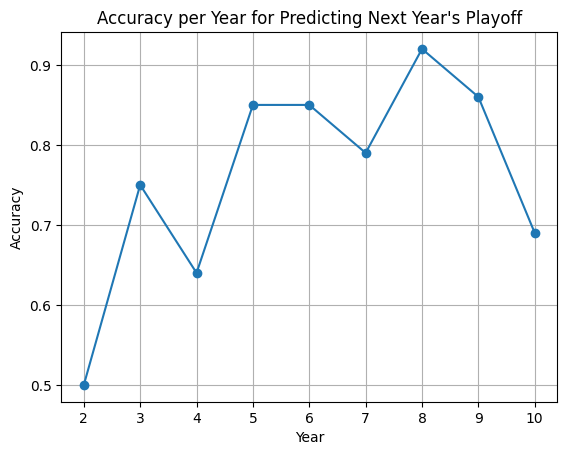

In [265]:
data['playoff'] = data['playoff'].replace({'Y': 1, 'N': 0})

def run_model():
    data1 = pd.get_dummies(data, columns=["tmID"])
    accuracy_list = []
    years = data1['year'].unique()
    years.sort()

    for i in range(1, len(years)):
        train_years = years[:i]
        test_year = years[i]

        train = data1[data1['year'].isin(train_years)]
        test = data1[data1['year'] == test_year]

        X_train = train.drop(columns=["playoff"])
        Y_train = train['playoff']
        X_test = test.drop(columns=["playoff"])
        Y_test = test['playoff']
        
        model = DecisionTreeClassifier(random_state=42)
        
        model.fit(X_train, Y_train)
        
        predictions = model.predict(X_test)
        
        accuracy = round(accuracy_score(Y_test, predictions), 2)
        print("Accuracy for year {}: {}".format(i + 1, accuracy))
        accuracy_list.append(accuracy)

    plt.plot(list(range(2, len(years) + 1)), accuracy_list, marker='o', linestyle='-')
    plt.xlabel("Year")
    plt.ylabel("Accuracy")
    plt.title("Accuracy per Year for Predicting Next Year's Playoff")
    plt.grid(True)
    plt.show()

run_model()

A different method to split the data:

Accuracy:  0.33
Accuracy:  0.83
Accuracy:  0.56
Accuracy:  0.68
Accuracy:  0.81
Accuracy:  0.71
Accuracy:  0.75
Accuracy:  0.84
Accuracy:  0.75


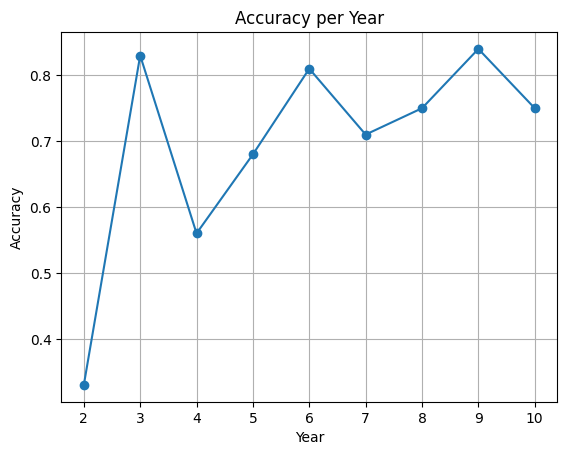

In [266]:
def run_model_1():
    data1 = pd.get_dummies(data, columns=["tmID"])
    accuracy_list = []
    years = data1['year'].unique()
    years.sort()

    for year in range(2, len(years) + 1):
        current_year_data = data1[data1['year'] == year]
        previous_years_data = data1[data1['year'] < year]

        current_year_data = current_year_data.copy()

        X = previous_years_data.drop(columns=["playoff"])
        
        Y = previous_years_data["playoff"]

        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.7, random_state=42)
        
        model = DecisionTreeClassifier(random_state=42)
        
        model.fit(X_train, Y_train)
        
        predictions = model.predict(X_test)
        
        accuracy = round(accuracy_score(Y_test, predictions), 2)
        print("Accuracy: ", accuracy)
        accuracy_list.append(accuracy)

    plt.plot(list(range(2, len(years) + 1)), accuracy_list, marker='o', linestyle='-')
    plt.xlabel("Year")
    plt.ylabel("Accuracy")
    plt.title("Accuracy per Year")
    plt.grid(True)
    plt.show()

run_model_1()

Adding the number of awards per team:

In [267]:
players_teams = pd.read_csv("basketballPlayoffs/players_teams.csv")
players_awards = pd.read_csv("basketballPlayoffs/awards_players.csv")

player_counts = players_awards['playerID'].value_counts().reset_index()
player_counts.columns = ['playerID', 'count']

print(player_counts.head(5))

     playerID  count
0  leslili01w     10
1  swoopsh01w      8
2  catchta01w      5
3  tauradi01w      4
4  jacksla01w      4


In [268]:
merged_data = player_counts.merge(players_teams[['playerID', 'tmID']], on='playerID', how='left')
merged_data = merged_data.drop_duplicates()
print(merged_data.head(5))

      playerID  count tmID
0   leslili01w     10  LAS
9   swoopsh01w      8  HOU
16  swoopsh01w      8  SEA
17  catchta01w      5  IND
25  tauradi01w      4  PHO


In [269]:
sum_data = merged_data.drop(columns=['playerID'])
#data = data.merge(sum_data[['tmID', 'count']], on='tmID', how='left')
#data.fillna(0, inplace=True)


print(data.head(5))

    year tmID  playoff  o_fgm  o_fga  o_ftm  o_fta  o_3pm  o_3pa  o_oreb  ...  \
2      1  CHA        0    812   1903    431    577    131    386     305  ...   
13     1  CLE        1    809   1828    426    570    141    407     331  ...   
24     1  DET        0    868   1980    519    699     76    273     341  ...   
34     1  HOU        1    891   1894    521    634    172    491     273  ...   
43     1  IND        0    796   1838    428    569    193    521     285  ...   

    tmDRB  tmTRB  opptmORB  opptmDRB  opptmTRB  won  lost  GP   min  attend  
2       0      0         0         0         0    8    24  32  6475   90963  
13      0      0         0         0         0   17    15  32  6500  137532  
24      0      0         0         0         0   14    18  32  6425  107289  
34      0      0         0         0         0   27     5  32  6475  196077  
43      0      0         0         0         0    9    23  32  6425  180270  

[5 rows x 44 columns]


Accuracy for year 2: 0.5
Accuracy for year 3: 0.75
Accuracy for year 4: 0.64
Accuracy for year 5: 0.85
Accuracy for year 6: 0.85


Accuracy for year 7: 0.79
Accuracy for year 8: 0.92
Accuracy for year 9: 0.86
Accuracy for year 10: 0.69


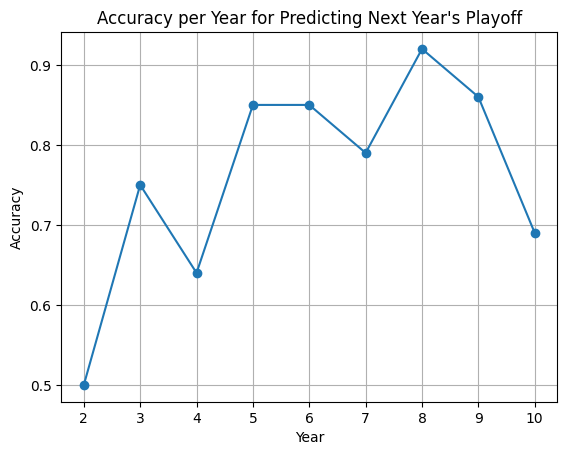

Accuracy:  0.33
Accuracy:  0.83
Accuracy:  0.56
Accuracy:  0.68
Accuracy:  0.81
Accuracy:  0.71
Accuracy:  0.75
Accuracy:  0.84
Accuracy:  0.75


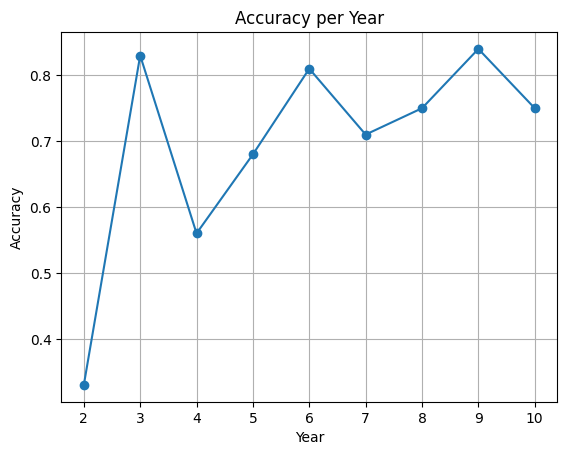

In [270]:
data1 = pd.get_dummies(data, columns=["tmID"])
run_model()
run_model_1()

Now we'll shift the data so that the statistics from one year are used to predict the playoffs of the following year:

In [271]:
def run_model_shift(data):
    print(data.shape[0])
    years = data['year'].unique()
    accuracy_list = []
    
    years.sort()
    all_teams = set()
    
    data = data.convert_dtypes()

    string_columns = data.select_dtypes(include=['string'])

    data[string_columns.columns] = string_columns.astype('category')

    # if 'i' is 2, we want to predict the playoffs in year 3, etc.
    for i in range(2, len(years)):
        train_years = years[:(i - 1)]
        train_years_2 = years[1:i]
        test_year = years[i]
        test_year_2 = years[i - 1]

        train = data[data['year'].isin(train_years)]
        train_2 = data[data['year'].isin(train_years_2)]
        test = data[data['year'] == test_year]
        test_2 = data[data['year'] == test_year_2]
        
        current_year_teams = test['tmID'].unique()

        if i > 2:
            new_teams = [team for team in current_year_teams if team not in all_teams]
            disappeared_teams = [team for team in all_teams if team not in current_year_teams]
            
            if new_teams:
                for team in new_teams:
                    #add row of nones to train_2
                    new_line = pd.DataFrame([[0] * len(test_2.columns)], columns=test_2.columns)
                    new_line['tmID'] = team
                    test_2 = pd.concat([test_2, new_line], ignore_index=True)
                    test_2 = test_2.convert_dtypes()
                    string_columns = test_2.select_dtypes(include=['string'])
                    test_2[string_columns.columns] = string_columns.astype('category')
            
            if disappeared_teams:
                for team in disappeared_teams:
                    #add row of nones to train
                    new_line = pd.DataFrame([[0] * len(test.columns)], columns=test.columns)
                    new_line['tmID'] = team
                    test = pd.concat([test, new_line], ignore_index=True)
                    test = test.convert_dtypes()
                    string_columns = test.select_dtypes(include=['string'])
                    test[string_columns.columns] = string_columns.astype('category')
         
        
        all_teams = current_year_teams
    
        X_train = train.drop(columns=["playoff"])
        Y_train = train_2['playoff']
        X_test = test_2.drop(columns=["playoff"])
        Y_test = test['playoff']


        print(X_train.shape[0])
        print(Y_train.shape[0])
        print(X_test.shape[0])
        print(Y_test.shape[0]) 
        model = lgb.LGBMClassifier(random_state=42)
        
        model.fit(X_train, Y_train)
       
        predictions = model.predict(X_test)
       

        accuracy = round(accuracy_score(Y_test, predictions), 2)
        print("Accuracy for year {}: {}".format(i + 1, accuracy))
        accuracy_list.append(accuracy)

    plt.plot(list(range(3, len(years) + 1)), accuracy_list, marker='o', linestyle='-')
    plt.xlabel("Year")
    plt.ylabel("Accuracy")
    plt.title("Accuracy per Year for Predicting Next Year's Playoff")
    plt.grid(True)
    plt.show()

run_model_shift(data)

142
16
16
16
16
[LightGBM] [Info] Number of positive: 8, number of negative: 8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3
[LightGBM] [Info] Number of data points in the train set: 16, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No

[LightGBM] [Fatal] Length of label is not same with #data


LightGBMError: Length of label is not same with #data